## Load Experiment Data

In [1]:
# Load the policy
import os
import pandas
from garage.experiment import Snapshotter
import pandas as pd
EXPERIMENT_NAME = "CL_point_env_9" #13
experiment_dir = os.path.join("data/local/experiment", EXPERIMENT_NAME)
snapshotter = Snapshotter()
data = snapshotter.load(experiment_dir)
policy = data['algo'].policy

# You can also access other components of the experiment
env = data['env']

progress_csv_path = os.path.join(experiment_dir, 'progress.csv')
# progress_df = pd.read_csv(progress_csv_path)

2025-01-08 09:57:31.227334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [2]:
num_train_tasks=2
from garage.experiment.task_sampler import SetTaskSampler
from garage.envs import GymEnv, normalize
from garage.envs.point_env import PointEnv
from garage.torch.algos.CLMeta import PEARLWorker

worker_args = dict(deterministic=True, accum_context=True)
env_sampler = SetTaskSampler(
    PointEnv,
    wrapper=lambda env, _: normalize(
        env))
env = env_sampler.sample(num_train_tasks)

In [3]:
from garage.experiment.meta_evaluator import MetaEvaluator

meta_evaluator = MetaEvaluator(test_tasks=env,
                               worker_class=PEARLWorker,
                               worker_args=worker_args,
                               n_exploration_eps=10,
                               n_test_tasks=2,
                               return_task_embeddings=True)

trajs, task_embeddings = meta_evaluator.evaluate(algo=data['algo'])

/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/meta_evaluator.py:86: LoggerWarning: No outputs have been added to the logger.
  logger.log('Sampling for adapation and meta-testing...')
/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/meta_evaluator.py:86: LoggerWarning: Log data of type str was not accepted by any output
  logger.log('Sampling for adapation and meta-testing...')
/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'garage.torch.distributions.tanh_normal.TanhNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/_dtypes.py:1051: UserWarning: Observation array([0., 0., 2.]) is outside observation_space Box(-inf, inf, (3,), float32)
  warnings.warn(




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




In [4]:
task_embeddings

[tensor([[ 0.2692,  0.6518,  0.0712,  0.2314, -0.6664]], grad_fn=<DivBackward0>),
 tensor([[-0.2300, -0.6438, -0.0254, -0.2351,  0.6905]], grad_fn=<DivBackward0>)]

Text(0.5, 1.0, 'Trajectories of Task 1 and Task 2')

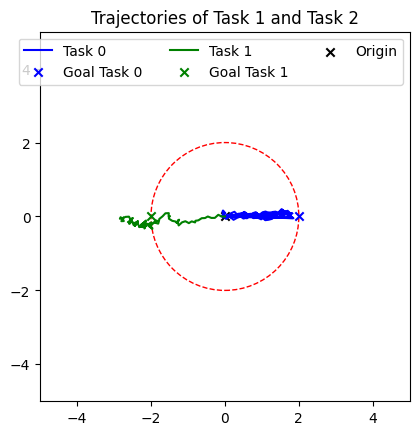

In [5]:


import matplotlib.pyplot as plt
plt.gca().set_aspect('equal', adjustable='box')
circle = plt.Circle((0, 0), 2, color='r', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
colors = ['blue', 'green', 'orange', 'purple', 'brown']
for idx_task, task_traj in enumerate(trajs):
    plt.plot(task_traj.observations[:,0], task_traj.observations[:,1], label=f"Task {idx_task}", color=colors[idx_task])
    plt.scatter(task_traj.env_infos["task"][0]["goal"][0], task_traj.env_infos["task"][0]["goal"][1], color=colors[idx_task], marker='x', label=f'Goal Task {idx_task}')
plt.scatter(0, 0, color='black', marker='x', label='Origin')
plt.legend(ncol=3)
plt.title("Trajectories of Task 1 and Task 2")

## Visualizing Learned Q-Functions

In [5]:
dir(data["algo"])
qf1 = data["algo"]._qf1
qf2 = data["algo"]._qf2

task_1_trajs

EpisodeBatch(env_spec=EnvSpec(input_space=Box(-0.1, 0.1, (2,), float32), output_space=Box(-inf, inf, (3,), float32), max_episode_length=100), episode_infos={}, observations=array([[ 0.00000000e+00,  0.00000000e+00,  2.00000000e+00],
       [ 7.40566477e-02,  8.26877728e-02,  1.92771758e+00],
       [ 1.72004774e-01,  8.09588730e-02,  1.82978711e+00],
       [ 2.46480279e-01,  1.26603983e-01,  1.75808418e+00],
       [ 3.28157812e-01,  1.59514010e-01,  1.67943473e+00],
       [ 4.11975585e-01,  1.23666093e-01,  1.59283233e+00],
       [ 5.06927863e-01,  5.07796481e-02,  1.49393540e+00],
       [ 5.26709013e-01,  7.56673142e-03,  1.47331042e+00],
       [ 6.19507924e-01,  1.91703849e-02,  1.38062518e+00],
       [ 7.11525045e-01, -2.31073163e-02,  1.28868214e+00],
       [ 8.08828801e-01, -3.00435834e-02,  1.19155002e+00],
       [ 9.00146402e-01, -6.71841539e-02,  1.10190365e+00],
       [ 9.98822212e-01,  2.37733498e-03,  1.00118061e+00],
       [ 1.08546747e+00, -3.79185937e-02,  9.15